In [3]:
import pandas as pd
from sklearn.model_selection import train_test_split
import nltk
import string
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
nltk.download('punkt')
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import precision_score, recall_score, precision_recall_curve, accuracy_score
from matplotlib import pyplot as plt
from sklearn.metrics import plot_precision_recall_curve
import numpy as np
from sklearn.model_selection import GridSearchCV

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Admin\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Подгрузил все необходимые библиотеки для дальнейшей работы.

In [4]:
df = pd.read_csv("labeled.csv", sep=",") #изначальный датасет
df.head() 

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1.0
1,"Хохлы, это отдушина затюканого россиянина, мол...",1.0
2,Собаке - собачья смерть\n,1.0
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1.0
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1.0


In [5]:
df["toxic"] = df["toxic"].apply(int) #так как все значения токсичности целочисленные, я изменил тип на int
df.head()

,comment,toxic
0,"Верблюдов-то за что? Дебилы, бл...\n",1
1,"Хохлы, это отдушина затюканого россиянина, мол...",1
2,Собаке - собачья смерть\n,1
3,"Страницу обнови, дебил. Это тоже не оскорблени...",1
4,"тебя не убедил 6-страничный пдф в том, что Скр...",1


In [6]:
df.shape

(14412, 2)

In [7]:
df["toxic"].value_counts() #количество положительных и отрицательных комментариев

0    9586
1    4826
Name: toxic, dtype: int64

In [8]:
df[df["toxic"] == 1].sample(5) #пример отрицательных комментариев

,comment,toxic
10942,"Етить налево, ох уж мне эта эпопея тупых баб, ...",1
6276,Точно так же я не верю что тут есть проплаченн...,1
795,"ебать ты конченый, нахуя ты это постишь?\n",1
10979,фуры с тварями за рулем никак не передохнут!!!...,1
5620,"Просто ты пидор, поэтому тебя и посещают такие...",1


In [9]:
df[df["toxic"] == 0].sample(5) #пример положительных комментариев

,comment,toxic
11482,"номер 10 зарезервирован,но есть еще и другие н...",0
9330,Что мешает скачать музыку с вк и загрузить на ...,0
7292,У нас это строение является объектом культурно...,0
9256,Что-то не очень на клевер похоже. У клевера бо...,0
3241,У меня 2 места багажа по 23 кг по условиям тар...,0


In [10]:
train_df, test_df = train_test_split(df, test_size=500) #разделим датасет на тренировочный и тестовый датасет

In [11]:
train_df.shape, test_df.shape

((13912, 2), (500, 2))

In [12]:
test_df["toxic"].value_counts() 

0    335
1    165
Name: toxic, dtype: int64

In [13]:
train_df["toxic"].value_counts() 

0    9251
1    4661
Name: toxic, dtype: int64

Отношения положительных и негативных комментариев

Обратка данных, чтобы улычшить качество модели

In [14]:
def tokenize_sentence(sentence): #функция, которая обработает каждый коммментарий 
    tokens = word_tokenize(sentence, language="russian") #разбиение на токены
    tokens = [i for i in tokens if i not in string.punctuation] #избавляемся от пунктуации 
    tokens = [i for i in tokens if i not in stopwords.words("russian")] #удаляем ненужные слова
    tokens = [SnowballStemmer(language="russian").stem(i) for i in tokens] #приводим к нижнему регистру и удаляем окончания
    tokens = [i for i in tokens if len(i)>1] #игнорируем 1-символьные токены
    return tokens

In [15]:
sentence_example = df.iloc[3]['comment']
tokenize_sentence(sentence_example) #токены после стемминга 

['страниц',
 'обнов',
 'деб',
 'эт',
 'оскорблен',
 'доказа',
 'факт',
 'не-деб',
 'множествен',
 'числ',
 'писа',
 'ил',
 'вер',
 'эт',
 'тво',
 'вообража',
 'друз']

Обучение предсказывающей модели

In [16]:
vectorizer = TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x)) #вычисление TF-IDF с заданным токенайзером

In [20]:
model_pipeline = Pipeline([("vectorizer", vectorizer),("model", LogisticRegression())])

In [21]:
model_pipeline.fit(train_df['comment'], train_df['toxic'])

Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000018985B61DC0>)),
                ('model', LogisticRegression())])

In [22]:
model_pipeline.predict(['я с такими конченными не общаюсь'])

array([1], dtype=int64)

Прогоним модель по 3 метрикам.

In [23]:
precision_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"])) #модель редко классифицирует обычные комментарии, как негативные

0.8782608695652174

In [24]:
recall_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"])) #много было незамеченных негативных комментариев

0.6121212121212121

In [25]:
accuracy_score(y_true=test_df["toxic"], y_pred=model_pipeline.predict(test_df["comment"])) #точность предсказаниям по всем предиктам

0.844

Постараюсь улучшить метрики с помощью GridSearch

In [36]:
grid_pipeline = Pipeline([
    ("vectorizer", TfidfVectorizer(tokenizer=lambda x: tokenize_sentence(x))),
    ("model", 
     GridSearchCV(
        LogisticRegression(),
        param_grid={'C': [0.1, 1, 10.]},
        cv = 5, verbose=True, n_jobs=-1
        )
    )
])

In [37]:
grid_pipeline.fit(train_df['comment'], train_df['toxic'])

Fitting 5 folds for each of 3 candidates, totalling 15 fits


C:\Users\Admin\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


Pipeline(steps=[('vectorizer',
                 TfidfVectorizer(tokenizer=<function <lambda> at 0x0000018985FD91F0>)),
                ('model',
                 GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
                              param_grid={'C': [0.1, 1, 10.0]},
                              verbose=True))])

In [38]:
precision_score(y_true=test_df["toxic"], y_pred=grid_pipeline.predict(test_df["comment"])) #модель редко классифицирует обычные комментарии, как негативные

0.8592592592592593

In [39]:
recall_score(y_true=test_df["toxic"], y_pred=grid_pipeline.predict(test_df["comment"])) #модель редко классифицирует обычные комментарии, как негативные

0.703030303030303

In [40]:
accuracy_score(y_true=test_df["toxic"], y_pred=grid_pipeline.predict(test_df["comment"])) #модель редко классифицирует обычные комментарии, как негативные

0.864

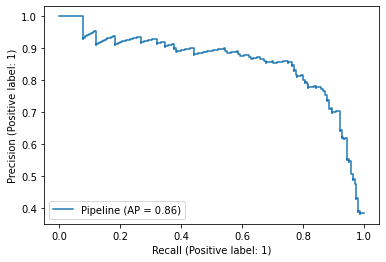

In [128]:
prec1, rec1, thresholds1 = precision_recall_curve(y_true=test_df["toxic"], probas_pred=model_pipeline.predict_proba(test_df["comment"])[:, 1])
 
plot_precision_recall_curve(estimator=model_pipeline, X=test_df["comment"], y=test_df["toxic"])
None

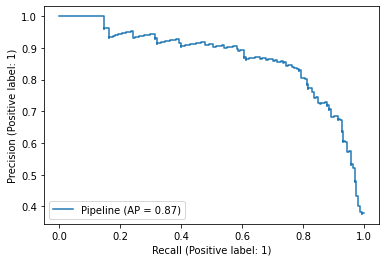

In [124]:
gr_prec, gr_rec, gr_thresholds = precision_recall_curve(y_true=test_df["toxic"], probas_pred=grid_pipeline.predict_proba(test_df["comment"])[:, 1])
 
plot_precision_recall_curve(estimator=grid_pipeline, X=test_df["comment"], y=test_df["toxic"])
None

In [123]:
from sklearn.metrics import classification_report
print('Valuation for model_pipeline:')
print(classification_report(test_df["toxic"], model_pipeline.predict(test_df["comment"])))
print("----------------------------------------------------------------------")
print('Valuation for grid_pipeline:')
print(classification_report(test_df["toxic"], grid_pipeline.predict(test_df["comment"])))

Valuation for model_pipeline:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89       335
           1       0.88      0.61      0.72       165

    accuracy                           0.84       500
   macro avg       0.86      0.79      0.81       500
weighted avg       0.85      0.84      0.84       500

----------------------------------------------------------------------
Valuation for grid_pipeline:
              precision    recall  f1-score   support

           0       0.87      0.94      0.90       335
           1       0.86      0.70      0.77       165

    accuracy                           0.86       500
   macro avg       0.86      0.82      0.84       500
weighted avg       0.86      0.86      0.86       500



Все средние значения увеличелись, удалось немного улучшить модель. 

In [115]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds):
    recall_90_precision = recalls[np.argmax(precisions >= 0.9)]
    threshold_90_precision = thresholds[np.argmax(precisions >= 0.9)]
    
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision", linewidth=2)
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall", linewidth=2)
    plt.xlabel("Threshold")
    plt.plot([threshold_90_precision, threshold_90_precision], [0., 0.9], "r:")
    plt.axis([-1, 1, 0.4, 1])
    plt.plot([-1, threshold_90_precision], [0.9, 0.9], "r:")
    plt.plot([-1, threshold_90_precision], [recall_90_precision, recall_90_precision], "r:")
    plt.plot([threshold_90_precision], [0.9], "ro") 
    plt.plot([threshold_90_precision], [recall_90_precision], "ro")
    plt.grid(True)
    plt.legend()
    plt.show()

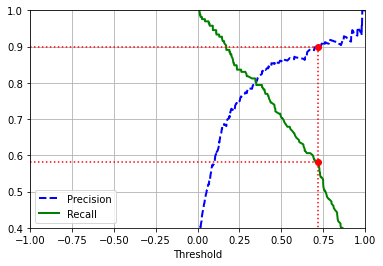

In [125]:
plot_precision_recall_vs_threshold(gr_prec, gr_rec, gr_thresholds)